In [1]:
!pwd

/massimal/python/dataset_specific/20220630_Juvika


In [2]:
import sys
sys.path.append("/massimal/python/tools")
#sys.path.append("/tf/workspace/massimal/python/massimal/tools")

In [3]:
# Imports
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
# "Local import" from massimal repository (https://github.com/mh-skjelvareid/massimal)
import annotation, image_render, hyspec_io, misc, hyspec_stats, hyspec_cnn
import importlib
#importlib.reload(hyspec_stats)

import sklearn.preprocessing
import sklearn.decomposition
import math

In [4]:
sys.path

['/massimal/python/dataset_specific/20220630_Juvika',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/massimal/python/tools']

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Parameters
TILE_SHAPE = (128,128)
TEST_FRAC = 0.3
# BATCH_SIZE = 16
# BATCH_SIZE = 32
BATCH_SIZE = 8

OUTPUT_CHANNELS = 7

In [7]:
# Paths
# base_dir = '/media/mha114/Massimal/Bodo_Juvika/Hyperspectral/20220624/'
base_dir = '/massimal/data/Bodo_Juvika/Hyperspectral/20220624/'

json_gray = base_dir + 'Area/M_Annotation/20220624_Juvika_AreaDetailed_v1/Annotations - grayscale/label_classes.json'
annotation_dir = base_dir + 'Area/M_Annotation/20220624_Juvika_AreaDetailed_v1/Annotations - grayscale'
hyspec_dir = base_dir + 'Area/2_R_rs'
dataset_filename = base_dir + 'Area/M_TensorFlow_Datasets/128-TilesWithWeights/128-TilesWithWeights'

In [8]:
# Load dataset
dataset = tf.data.Dataset.load(dataset_filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


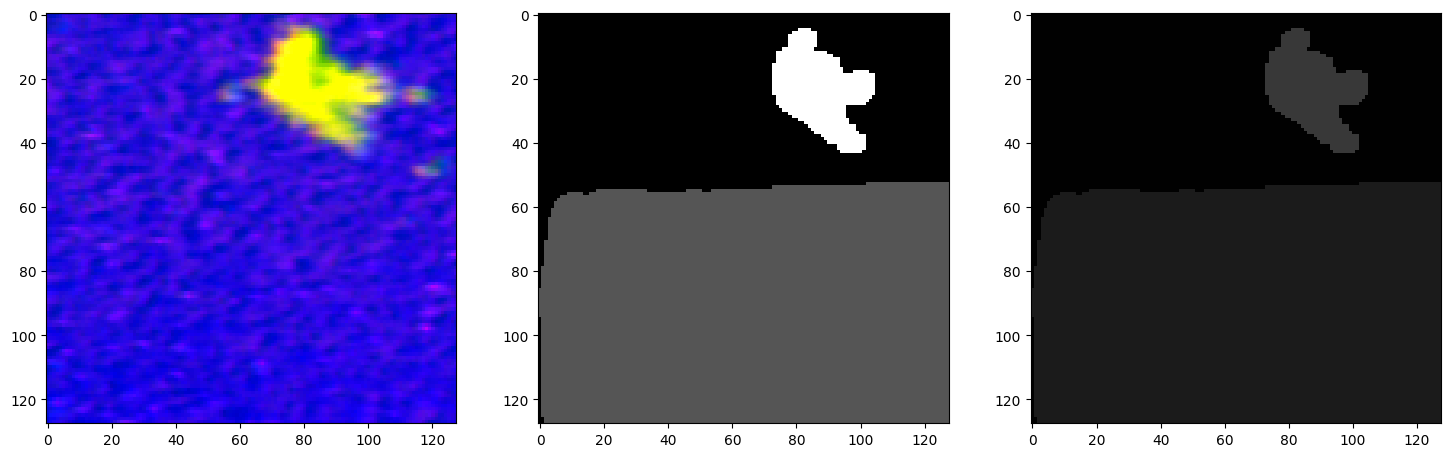

In [9]:
# Show some of the elements of the dataset
for image, mask, weights in dataset.take(1):    # Note: Must interate over dataset to "get" elements
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(image)[:,:,0:3]))
    ax[1].imshow(np.array(mask),cmap='gray')
    ax[2].imshow(np.array(weights),cmap='gray',vmin=0,vmax=20)
    plt.show()

In [11]:
wgts = np.array(weights)
print(np.max(wgts))
print(np.min(wgts))

4.3942475
0.1


In [12]:
print(len(dataset))

257


In [38]:
# Split into training and validation datasets, create batches
n_val_tiles = int(TEST_FRAC*len(dataset))

dataset = dataset.shuffle(len(dataset))
val_dataset = dataset.take(n_val_tiles).batch(BATCH_SIZE)
train_dataset = dataset.skip(n_val_tiles).batch(BATCH_SIZE)

In [39]:
# Create the U-Net model
unet = hyspec_cnn.unet(input_channels=dataset.element_spec[0].shape[-1],
                       output_channels=OUTPUT_CHANNELS,
                       first_layer_channels=32,
                       depth = 5,
                       apply_batchnorm=True,
                       apply_dropout=True,
                       flip_aug=False,
                       trans_aug=False)
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 10)]                                                             
                                                                                                  
 initial_convolution (Conv2D)   (None, None, None,   2912        ['input_image[0][0]']            
                                32)                                                               
                                                                                                  
 downsamp_res_1/2 (Sequential)  (None, None, None,   33024       ['initial_convolution[0][0]']    
                                64)                                                         

In [40]:
# Compile model. NOTE: Need smaller learning rate than standard RMSprop
# unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), 
#              loss="sparse_categorical_crossentropy",
#              weighted_metrics=[])

unet.compile(optimizer=tf.keras.optimizers.Adam(0.00002), 
             loss="sparse_categorical_crossentropy",
             weighted_metrics=[])

In [41]:
# Fit model to dataset
history = unet.fit(train_dataset,
                   epochs=100,
                   validation_data=val_dataset)


Epoch 1/100
23/23 [==============================] - 17s 547ms/step - loss: 5.1547 - val_loss: 4.0018
Epoch 2/100
23/23 [==============================] - 12s 531ms/step - loss: 4.2196 - val_loss: 3.8161
Epoch 3/100
23/23 [==============================] - 12s 534ms/step - loss: 3.9377 - val_loss: 3.6073
Epoch 4/100
23/23 [==============================] - 12s 530ms/step - loss: 4.0477 - val_loss: 4.2302
Epoch 5/100
23/23 [==============================] - 12s 531ms/step - loss: 3.8141 - val_loss: 3.8285
Epoch 6/100
23/23 [==============================] - 12s 531ms/step - loss: 3.4957 - val_loss: 4.2916
Epoch 7/100
23/23 [==============================] - 12s 534ms/step - loss: 3.3323 - val_loss: 4.0824
Epoch 8/100
23/23 [==============================] - 12s 535ms/step - loss: 3.3197 - val_loss: 3.8238
Epoch 9/100
23/23 [==============================] - 13s 538ms/step - loss: 3.3630 - val_loss: 2.8889
Epoch 10/100
23/23 [==============================] - 12s 536ms/step - loss: 3.229

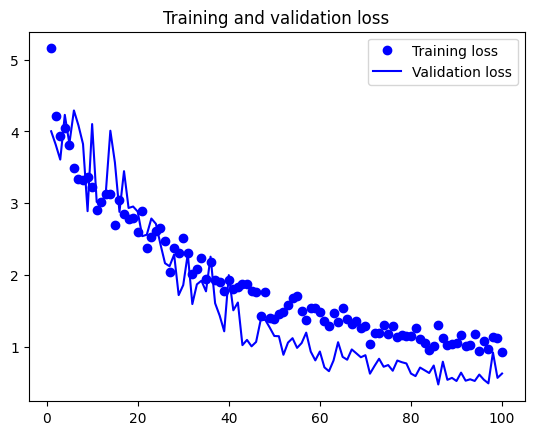

In [42]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [44]:
# Reduce learning rate
unet.optimizer.learning_rate.assign(0.000002)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2e-06>

In [46]:
unet.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2e-06>

In [47]:
# Fit model to dataset (resume)
history = unet.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset)

Epoch 1/50
23/23 [==============================] - 13s 542ms/step - loss: 0.9577 - val_loss: 0.5049
Epoch 2/50
23/23 [==============================] - 13s 538ms/step - loss: 0.8214 - val_loss: 0.5722
Epoch 3/50
23/23 [==============================] - 12s 535ms/step - loss: 1.0214 - val_loss: 0.4530
Epoch 4/50
23/23 [==============================] - 12s 534ms/step - loss: 0.9078 - val_loss: 0.4948
Epoch 5/50
23/23 [==============================] - 12s 539ms/step - loss: 1.0056 - val_loss: 0.4902
Epoch 6/50
23/23 [==============================] - 12s 537ms/step - loss: 0.8042 - val_loss: 0.4763
Epoch 7/50
23/23 [==============================] - 12s 537ms/step - loss: 0.9099 - val_loss: 0.4665
Epoch 8/50
23/23 [==============================] - 12s 537ms/step - loss: 0.9688 - val_loss: 0.5446
Epoch 9/50
23/23 [==============================] - 12s 530ms/step - loss: 0.8499 - val_loss: 0.5472
Epoch 10/50
23/23 [==============================] - 12s 531ms/step - loss: 0.9236 - val_lo

In [48]:
unet.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 2e-06,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

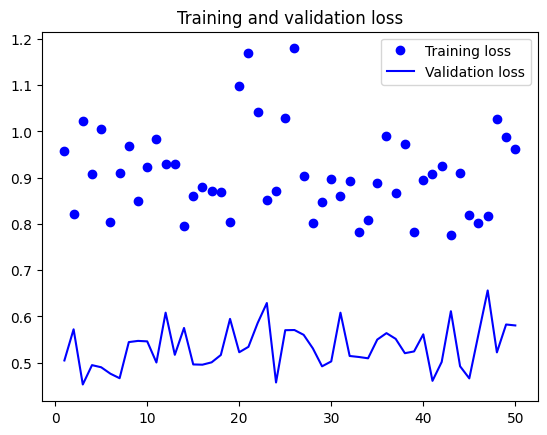

In [49]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()